# Training an Attention Model on Tensorflow Datasets
## Prerequisites

In [1]:
import json
import math
import os
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.core.display import display
from mmproteo.utils import log, paths, utils, visualization
from mmproteo.utils.formats.tf_dataset import DatasetLoader
from mmproteo.utils.ml import callbacks, evaluation
from official.modeling import tf_utils
from official.nlp.modeling.models.seq2seq_transformer import Seq2SeqTransformer, TransformerDecoder, TransformerEncoder
from official.nlp.modeling.ops import beam_search

In [2]:
from tensorflow.python.keras.metrics import MeanMetricWrapper
from tensorflow.python.ops import array_ops, math_ops
from tensorflow.python.keras import backend
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [5]:
#tf.debugging.set_log_device_placement(True)
GPUs = tf.config.list_physical_devices('GPU')
GPUs

[]

## Configuration

In [6]:
!pwd

/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks


In [7]:
if os.getcwd() == "/tf":
    os.chdir(os.path.join('workspace', 'notebooks'))

In [8]:
!pwd

/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks


In [9]:
DUMP_PATH = "/scratch/mirko.krause/pdeep"
TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "file_*.parquet")

In [10]:
print(f"dump path = {DUMP_PATH}")
THREAD_COUNT = min(int(os.cpu_count()/2), 16)
STATISTICS_FILE_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "statistics.parquet")
DATASET_DUMP_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "tf_datasets")
PROCESSING_FILE_PATH = os.path.join(DATASET_DUMP_PATH, "processing_info.json")

dump path = /scratch/mirko.krause/pdeep


In [11]:
SEQ = 'peptide_sequence'

In [12]:
logger = log.create_logger(
    name='mmproteo_attention_model',
    verbose=True,
    log_dir=DUMP_PATH,
)

2021-08-16 11:44:09,540 - mmproteo_attention_model: Logging to file '/scratch/mirko.krause/pdeep/mmproteo_attention_model.log' and to stderr


In [13]:
with open(PROCESSING_FILE_PATH, 'r') as file:
    PROCESSING_INFO = json.loads(file.read())
PROCESSING_INFO

{'padding_characters': {'peptide_sequence': '_',
  'mz_array': 0.0,
  'intensity_array': 0.0},
 'padding_lengths': {'mz_array': 89,
  'intensity_array': 89,
  'peptide_sequence': 30},
 'idx_to_char': {'0': 'A',
  '1': 'C',
  '2': 'D',
  '3': 'E',
  '4': 'F',
  '5': 'G',
  '6': 'H',
  '7': 'I',
  '8': 'K',
  '9': 'L',
  '10': 'M',
  '11': 'N',
  '12': 'P',
  '13': 'Q',
  '14': 'R',
  '15': 'S',
  '16': 'T',
  '17': 'V',
  '18': 'W',
  '19': 'Y',
  '20': '_'},
 'normalization': {'intensity_array': '<function base_peak_normalize at 0x7f9e3ee96af0>'},
 'split_value_columns': None,
 'training_data_columns': ['mz_array', 'intensity_array'],
 'target_data_columns': ['peptide_sequence'],
 'element_spec': '((TensorSpec(shape=(89,), dtype=tf.float64, name=None), TensorSpec(shape=(89,), dtype=tf.float64, name=None)), (TensorSpec(shape=(30,), dtype=tf.int8, name=None),))'}

In [14]:
def find_grouping_path_position(cols: Optional[List[str]], prefered_item: str, alternative_index: int = -1) -> int:
    res = alternative_index
    if cols is not None:
        try:
            res = cols.index(prefered_item) - len(cols)
        except ValueError:
            pass
    return res

In [15]:
grouping_path_position = find_grouping_path_position(
    cols=PROCESSING_INFO['split_value_columns'],
    prefered_item='species',
    alternative_index=-1,
)
grouping_path_position

-1

In [16]:
idx_to_char = {int(idx): char for idx, char in PROCESSING_INFO["idx_to_char"].items()}
#idx_to_char[-1] = "[start]"
char_to_idx = {char: idx for idx, char in idx_to_char.items()}

## Loading Tensorflow Datasets

In [17]:
KEEP_CACHE = False

In [18]:
BATCH_SIZE = 512

In [19]:
TRAIN_TYPE = 'Train'
TEST_TYPE = 'Test'
EVAL_TYPE = 'Eval'

In [20]:
dataset_file_paths = paths.assign_wildcard_paths_to_splits_grouped_by_path_position_value(
    wildcard_path = os.path.join(
        DATASET_DUMP_PATH, 
        '*.parquet',  # filename
        *(['*' for _ in PROCESSING_INFO['split_value_columns']] or [])
    ),
    path_position = grouping_path_position,
    splits = {
            TRAIN_TYPE: 0.8,
            TEST_TYPE: 0.9,
            EVAL_TYPE: 1.0
        },
    paths_dump_file = os.path.join(
            DATASET_DUMP_PATH,
            "dataset_file_paths.json"
        ),
    skip_existing = KEEP_CACHE,
    logger = logger
)

print()
print("assigned dataset files:")
visualization.print_list_length_in_dict(dataset_file_paths)


assigned dataset files:
#Train = 20
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_17.parquet
#Test = 3
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_21.parquet
#Eval = 3
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_14.parquet


2021-08-16 11:44:09,566 - mmproteo_attention_model: DEBUG: assigned values:
2021-08-16 11:44:09,567 - mmproteo_attention_model: DEBUG: #Train = 20
2021-08-16 11:44:09,567 - mmproteo_attention_model: DEBUG: e.g.: file_17.parquet
2021-08-16 11:44:09,567 - mmproteo_attention_model: DEBUG: #Test = 3
2021-08-16 11:44:09,567 - mmproteo_attention_model: DEBUG: e.g.: file_21.parquet
2021-08-16 11:44:09,567 - mmproteo_attention_model: DEBUG: #Eval = 3
2021-08-16 11:44:09,568 - mmproteo_attention_model: DEBUG: e.g.: file_14.parquet
2021-08-16 11:44:09,568 - mmproteo_attention_model: DEBUG: assigned paths:
2021-08-16 11:44:09,568 - mmproteo_attention_model: DEBUG: #Train = 20
2021-08-16 11:44:09,568 - mmproteo_attention_model: DEBUG: e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_17.parquet
2021-08-16 11:44:09,569 - mmproteo_attention_model: DEBUG: #Test = 3
2021-08-16 11:44:09,569 - mmproteo_attention_model: DEBUG: e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datase

### Loading corresponding TF datasets

In [21]:
element_spec = eval(PROCESSING_INFO['element_spec'], {}, {'TensorSpec':tf.TensorSpec, 'tf':tf})
element_spec

((TensorSpec(shape=(89,), dtype=tf.float64, name=None),
  TensorSpec(shape=(89,), dtype=tf.float64, name=None)),
 (TensorSpec(shape=(30,), dtype=tf.int8, name=None),))

**In the following step, Tensorflow starts allocating a GPU**

In [22]:
# initialize Tensorflow (might take several minutes (~5 minutes per GPU with 40GB VRAM each))
logger.debug("started initializing tensorflow by creating a first dataset")
tf.data.Dataset.range(5)
logger.info("finished initializing tensorflow")

2021-08-16 11:44:09,576 - mmproteo_attention_model: DEBUG: started initializing tensorflow by creating a first dataset
2021-08-16 11:44:09,611 - mmproteo_attention_model: finished initializing tensorflow


In [23]:
ds_options = tf.data.Options()
ds_options.experimental_threading.private_threadpool_size = THREAD_COUNT
ds_options.experimental_threading.max_intra_op_parallelism = THREAD_COUNT

In [24]:
datasets = DatasetLoader(
    element_spec=element_spec,
    batch_size=BATCH_SIZE,
    shuffle_buffer_size=100_000,
    thread_count=min(int(os.cpu_count()/4), 4),
    keep_cache=KEEP_CACHE,
    logger=logger,
    run_benchmarks=False,
    options=ds_options,
).load_datasets_by_type(dataset_file_paths)
datasets

2021-08-16 11:44:09,620 - mmproteo_attention_model: DEBUG: preparing dataset 'Train' with 20 paths
2021-08-16 11:44:09,622 - mmproteo_attention_model: DEBUG: applied options to dataset 'Train'
2021-08-16 11:44:09,667 - mmproteo_attention_model: DEBUG: loaded dataset 'Train' interleaved
2021-08-16 11:44:09,667 - mmproteo_attention_model: DEBUG: shuffled dataset 'Train'
2021-08-16 11:44:09,668 - mmproteo_attention_model: DEBUG: batched dataset 'Train'
2021-08-16 11:44:09,668 - mmproteo_attention_model: DEBUG: skipped caching dataset 'Train'
2021-08-16 11:44:09,669 - mmproteo_attention_model: DEBUG: configured prefetching for dataset 'Train'
2021-08-16 11:44:09,669 - mmproteo_attention_model: DEBUG: skipped benchmarking dataset 'Train'
2021-08-16 11:44:09,669 - mmproteo_attention_model: prepared dataset 'Train'
2021-08-16 11:44:09,669 - mmproteo_attention_model: DEBUG: preparing dataset 'Test' with 3 paths
2021-08-16 11:44:09,669 - mmproteo_attention_model: DEBUG: applied options to datas

{'Train': <PrefetchDataset shapes: (((512, 89), (512, 89)), ((512, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>,
 'Test': <PrefetchDataset shapes: (((512, 89), (512, 89)), ((512, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>,
 'Eval': <PrefetchDataset shapes: (((512, 89), (512, 89)), ((512, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>}

In [25]:
original_datasets = datasets

In [26]:
def prefix_target_sequences_with_start_token(tensor: tf.Tensor, token: Any = -1) -> tf.Tensor:
    return tf.concat(
        values=[
            tf.broadcast_to(
                input=tf.constant(token, dtype=tensor.dtype),
                shape=(
                    tensor.shape[0],  # batch dimension
                    1
                )
            ),
            tensor
        ],
        axis=1
    )


def _dataset_mapper_for_transformer(trainings: Tuple[tf.Tensor], targets: Tuple[tf.Tensor]) \
-> Tuple[Dict[str, tf.data.Dataset], tf.data.Dataset]:
    inputs = tf.stack(trainings, axis=-1)[:, :500, :]  # cut off too long spectra
    inputs = tf.cast(x=inputs, dtype=tf.float32)
    targets = prefix_target_sequences_with_start_token(targets[0])
    targets = tf.cast(
        x=targets,
        dtype=tf.int32,
    )

    return (
        {
            "inputs": inputs,
            "targets": targets[:, :-1],
        },
        targets[:, 1:]
    )


def prepare_dataset_for_transformer_training(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(_dataset_mapper_for_transformer)

In [27]:
# use these methods if the model shifts the target input itself

def _dataset_mapper_for_transformer_unshifted(trainings: Tuple[tf.Tensor], targets: Tuple[tf.Tensor]) \
-> Tuple[Dict[str, tf.data.Dataset], tf.data.Dataset]:
    inputs = tf.stack(trainings, axis=-1)[:, :500, :]  # cut off too long spectra
    inputs = tf.cast(x=inputs, dtype=tf.float32)

    targets = tf.cast(
        x=targets[0],
        dtype=tf.int32,
    )

    return (
        {
            "inputs": inputs,
            "targets": targets,
        },
        targets
    )

def prepare_dataset_for_transformer_training_unshifted(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(_dataset_mapper_for_transformer_unshifted)

In [28]:
datasets = {
    t: prepare_dataset_for_transformer_training_unshifted(dataset) for t, dataset in original_datasets.items()
}
datasets

{'Train': <MapDataset shapes: ({inputs: (512, 89, 2), targets: (512, 30)}, (512, 30)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>,
 'Test': <MapDataset shapes: ({inputs: (512, 89, 2), targets: (512, 30)}, (512, 30)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>,
 'Eval': <MapDataset shapes: ({inputs: (512, 89, 2), targets: (512, 30)}, (512, 30)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>}

In [29]:
print("original datasets:")
display(tfds.benchmark(original_datasets[TEST_TYPE]))

print()

print("mapped datasets:")
display(tfds.benchmark(datasets[TEST_TYPE]))

original datasets:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 223.75 ex/sec (total: 5855 ex, 26.17 sec)
Examples/sec (First only) 1.85 ex/sec (total: 1 ex, 0.54 sec)
Examples/sec (First excluded) 228.43 ex/sec (total: 5854 ex, 25.63 sec)


,duration,num_examples,avg
first+lasts,26.167154,5855,223.753796
first,0.540323,1,1.850745
lasts,25.626831,5854,228.432460



mapped datasets:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 229.14 ex/sec (total: 5855 ex, 25.55 sec)
Examples/sec (First only) 1.84 ex/sec (total: 1 ex, 0.54 sec)
Examples/sec (First excluded) 234.09 ex/sec (total: 5854 ex, 25.01 sec)


,duration,num_examples,avg
first+lasts,25.551702,5855,229.143252
first,0.544430,1,1.836782
lasts,25.007271,5854,234.091915


## Building the Tensorflow Model

In [30]:
# taken from: https://github.com/tensorflow/models/blob/027813d334645d6076a72b41b7b87ec30334cbb1/official/nlp/modeling/layers/position_embedding.py#L91
def embed_with_sin_and_cos(positions: Union[tf.Tensor, np.ndarray], embedding_width: int) -> tf.Tensor:
    """
    positions: a tensor with the dimensions [batch_size, item count]
    """
    # constants
    num_timescales = embedding_width // 2
    min_timescale, max_timescale = 1.0, 1.0e4
    log_timescale_increment = (
        math.log(float(max_timescale) / float(min_timescale)) /
        (tf.cast(num_timescales, tf.float32) - 1))
    inv_timescales = min_timescale * tf.exp(
        tf.cast(tf.range(num_timescales), tf.float32) *
        -log_timescale_increment)

    # calculations
    scaled_time = tf.expand_dims(positions, -1) * tf.expand_dims(
        inv_timescales, 0)
    position_embeddings = tf.concat(
        [tf.sin(scaled_time), tf.cos(scaled_time)], axis=-1)
    return position_embeddings

In [31]:
char_to_idx[PROCESSING_INFO['padding_characters'][SEQ]]

20

In [145]:
# heavily based on:
# https://github.com/tensorflow/models/blob/master/official/nlp/modeling/models/seq2seq_transformer.py
# (29.06.2021)
class MyTransformer(Seq2SeqTransformer):
    _eos_id: int = char_to_idx[PROCESSING_INFO['padding_characters'][SEQ]]
        
    def call(self, inputs):
        """Calculate target logits or inferred target sequences.
        Args:
          inputs: a dictionary of tensors.
            Feature `inputs`: int tensor with shape `[batch_size, input_length]`.
            Feature `targets` (optional): None or int tensor with shape
              `[batch_size, target_length]`.
        Returns:
          If targets is defined, then return logits for each word in the target
          sequence, which is a float tensor with shape
          `(batch_size, target_length, vocab_size)`. If target is `None`, then
          generate output sequence one token at a time and
          returns a dictionary {
              outputs: `(batch_size, decoded_length)`
              scores: `(batch_size, 1)`}
          Even when `float16` is used, the output tensor(s) are always `float32`.
        Raises:
          NotImplementedError: If try to use padded decode method on CPU/GPUs.
        """
        sources = inputs["inputs"]
        mz = sources[:, :, 0]
        intensities = sources[:, :, 1]
        targets = inputs.get("targets", None)
        
        # Prepare inputs to the layer stack by adding positional encodings and applying dropout.

        embedded_mz = embed_with_sin_and_cos(mz, self._embedding_width)
        embedded_intensities = embedded_mz * tf.expand_dims(intensities, -1)
    
        sources = embedded_intensities
        
        # Attention_mask generation.
        input_shape = tf_utils.get_shape_list(sources, expected_rank=3)
        batch_size = input_shape[0]
        input_length = input_shape[1]
        channel_count = input_shape[2]
        non_padding_sources = tf.not_equal(mz, 0.0)
        non_padding_sources = tf.reshape(
            tensor=non_padding_sources,
            shape=[batch_size, 1, input_length]
        )
        attention_mask = tf.cast(
            x=non_padding_sources,
            dtype=sources.dtype
        )
        broadcast_ones = tf.ones(
            shape=[batch_size, input_length, 1],
            dtype=sources.dtype
        )
        attention_mask = broadcast_ones * attention_mask

        encoder_inputs = self.encoder_dropout(sources)

        encoder_outputs = self.encoder_layer(
            encoder_inputs, attention_mask=attention_mask)
        
        if targets is None:
            if self._padded_decode:
                max_decode_length = self._decode_max_length
            else:
                max_decode_length = self._decode_max_length or (
                        tf.shape(encoder_outputs)[1] + self._extra_decode_length)
            symbols_to_logits_fn = self._get_symbols_to_logits_fn(max_decode_length)

            #batch_size = tf.shape(encoder_outputs)[0]
            # Create initial set of IDs that will be passed to symbols_to_logits_fn.
            initial_ids = tf.zeros([batch_size], dtype=tf.int32)

            # Create cache storing decoder attention values for each layer.
            init_decode_length = (max_decode_length if self._padded_decode else 0)
            num_heads = self.decoder_layer.num_attention_heads
            dim_per_head = self._embedding_width // num_heads

            # Cache dtype needs to match beam_search dtype.
            # pylint: disable=g-complex-comprehension
            cache = {
                str(layer): {
                    "key":
                        tf.zeros(
                            [batch_size, init_decode_length, num_heads, dim_per_head],
                            dtype=self.compute_dtype),
                    "value":
                        tf.zeros(
                            [batch_size, init_decode_length, num_heads, dim_per_head],
                            dtype=self.compute_dtype)
                } for layer in range(self.decoder_layer.num_layers)
            }
            # pylint: enable=g-complex-comprehension

            # Add encoder output and attention bias to the cache.
            encoder_outputs = tf.cast(encoder_outputs, dtype=self.compute_dtype)
            
            #attention_mask = tf.cast(
            #    tf.reshape(
            #        tf.not_equal(sources, 0), [batch_size, 1, input_length]),
            #    dtype=self.compute_dtype)
            attention_mask = tf.cast(
                    tf.not_equal(sources, 0),
                dtype=self.compute_dtype)
            cache["encoder_outputs"] = encoder_outputs
            cache["encoder_decoder_attention_mask"] = attention_mask
            
            search_parameters = {
                "initial_ids": initial_ids,
                "initial_cache": cache,
                "vocab_size": self._vocab_size,
                "beam_size": self._beam_size,
                "alpha": self._alpha,
                "max_decode_length": max_decode_length,
                "eos_id": self._eos_id,
                "padded_decode": self._padded_decode
            }
            #return search_parameters
        
            # Use beam search to find the top beam_size sequences and scores.
            decoded_ids, scores = beam_search.sequence_beam_search(
                symbols_to_logits_fn=symbols_to_logits_fn,
                initial_ids=initial_ids,
                initial_cache=cache,
                vocab_size=self._vocab_size,
                beam_size=self._beam_size,
                alpha=self._alpha,
                max_decode_length=max_decode_length,
                eos_id=self._eos_id,
                padded_decode=self._padded_decode,
                dtype=self.compute_dtype)

            # Get the top sequence for each batch element
            top_decoded_ids = decoded_ids[:, 0, 1:]
            top_scores = scores[:, 0]

            return {"outputs": top_decoded_ids, "scores": top_scores}

        decoder_inputs = self.embedding_lookup(targets)
        embedding_mask = tf.cast(tf.not_equal(targets, 0), decoder_inputs.dtype)
        decoder_inputs *= tf.expand_dims(embedding_mask, -1)
        # Shift targets to the right, and remove the last element
        # seems smarter than the dataset approach
        decoder_inputs = tf.pad(decoder_inputs, [[0, 0], [1, 0], [0, 0]])[:, :-1, :]
        
        length = tf.shape(decoder_inputs)[1]
        pos_encoding = self.position_embedding(decoder_inputs)
        pos_encoding = tf.cast(pos_encoding, decoder_inputs.dtype)
        decoder_inputs += pos_encoding

        decoder_inputs = self.decoder_dropout(decoder_inputs)

        decoder_shape = tf_utils.get_shape_list(decoder_inputs, expected_rank=3)
        batch_size = decoder_shape[0]
        decoder_length = decoder_shape[1]

        self_attention_mask = tf.linalg.band_part(tf.ones([length, length]), -1, 0)
        self_attention_mask = tf.reshape(self_attention_mask, [1, length, length])
        self_attention_mask = tf.tile(self_attention_mask, [batch_size, 1, 1])

        attention_mask = tf.cast(
            tf.expand_dims(tf.not_equal(sources[:, :, 0], 0), axis=1), dtype=sources.dtype)
        attention_mask = tf.tile(attention_mask, [1, decoder_length, 1])

        outputs = self.decoder_layer(
            decoder_inputs,
            encoder_outputs,
            memory_mask=self_attention_mask,
            target_mask=attention_mask)
        
        logits = self._embedding_linear(self.embedding_lookup.embeddings, outputs)
        # Model outputs should be float32 to avoid numeric issues.
        # https://www.tensorflow.org/guide/mixed_precision#building_the_model
        logits = tf.cast(logits, tf.float32)
        return logits

In [146]:
model = create_model()
res = model.predict(target_less_input)
res

2021-08-16 13:58:01,124 - mmproteo_attention_model: created new model 'mmproteo_transformer_20210816-135801'


INFO:tensorflow:Error reported to Coordinator: in user code:

    <ipython-input-145-c0d4efa2cfca>:122 call  *
        decoded_ids, scores = beam_search.sequence_beam_search(
    /scratch/mirko.krause/anaconda3/envs/mmproteo/lib/python3.8/site-packages/official/nlp/modeling/ops/beam_search.py:579 sequence_beam_search  *
        return sbs.search(initial_ids, initial_cache)
    /scratch/mirko.krause/anaconda3/envs/mmproteo/lib/python3.8/site-packages/official/nlp/modeling/ops/beam_search.py:194 _grow_alive_seq  *
        flat_logits, flat_cache = self.symbols_to_logits_fn(
    /tmp/tmp092427as.py:56 symbols_to_logits_fn  **
        attention_bias = ag__.converted_call(ag__.ld(tf).where, ((ag__.ld(attention_bias) < 0), ag__.converted_call(ag__.ld(tf).zeros_like, (ag__.ld(attention_bias),), None, fscope_1), ag__.converted_call(ag__.ld(tf).ones_like, (ag__.ld(attention_bias),), None, fscope_1)), None, fscope_1)

    TypeError: '<' not supported between instances of 'NoneType' and 'int'
Tra

TypeError: in user code:

    /scratch/mirko.krause/anaconda3/envs/mmproteo/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    <ipython-input-145-c0d4efa2cfca>:122 call  *
        decoded_ids, scores = beam_search.sequence_beam_search(
    /scratch/mirko.krause/anaconda3/envs/mmproteo/lib/python3.8/site-packages/official/nlp/modeling/ops/beam_search.py:579 sequence_beam_search  *
        return sbs.search(initial_ids, initial_cache)
    /scratch/mirko.krause/anaconda3/envs/mmproteo/lib/python3.8/site-packages/official/nlp/modeling/ops/beam_search.py:194 _grow_alive_seq  *
        flat_logits, flat_cache = self.symbols_to_logits_fn(
    /tmp/tmp092427as.py:56 symbols_to_logits_fn  **
        attention_bias = ag__.converted_call(ag__.ld(tf).where, ((ag__.ld(attention_bias) < 0), ag__.converted_call(ag__.ld(tf).zeros_like, (ag__.ld(attention_bias),), None, fscope_1), ag__.converted_call(ag__.ld(tf).ones_like, (ag__.ld(attention_bias),), None, fscope_1)), None, fscope_1)

    TypeError: '<' not supported between instances of 'NoneType' and 'int'


In [97]:
res[]

(2, 512)

In [90]:
def jaccard_distance(elem):
    i_true, i_pred = elem[0], elem[1]
    unique_true, _ = tf.unique(i_true)
    unique_pred, _ = tf.unique(i_pred)
    n_unique_true = tf.shape(unique_true)[0]
    n_unique_pred = tf.shape(unique_pred)[0]
    unique_all, _ = tf.unique(tf.concat(values=[unique_true, unique_pred], axis=-1))
    n_unique_all = tf.shape(unique_all)[0]
    n_overlap = n_unique_true + n_unique_pred - n_unique_all
    return n_overlap / n_unique_all

def jaccard_batch_distance(y_true, y_pred):
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = ops.convert_to_tensor_v2_with_dispatch(y_true)
    y_pred_rank = y_pred.shape.ndims
    y_true_rank = y_true.shape.ndims
    # If the shape of y_true is (num_samples, 1), squeeze to (num_samples,)
    if (y_true_rank is not None) and (y_pred_rank is not None) and (len(
            backend.int_shape(y_true)) == len(backend.int_shape(y_pred))):
        y_true = array_ops.squeeze(y_true, [-1])
    y_pred = math_ops.argmax(y_pred, axis=-1)

    # If the predicted output and actual output types don't match, force cast them
    # to match.
    if backend.dtype(y_pred) != backend.dtype(y_true):
        y_pred = math_ops.cast(y_pred, backend.dtype(y_true))
    
    # 0th dimension is the batch
    jaccard = tf.map_fn(fn=jaccard_distance, elems=(y_true, y_pred), fn_output_signature=tf.float64)
    return math_ops.cast(jaccard, backend.floatx())
    

class JaccardBatchDistance(MeanMetricWrapper):
    def __init__(self, name='jaccard_batch_distance', dtype=None):
        super(JaccardBatchDistance, self).__init__(
            jaccard_batch_distance, name, dtype=dtype)

In [34]:
def leuvenshtein_sparse_tensor_batch_distance(y_true: tf.sparse.SparseTensor, y_pred: tf.sparse.SparseTensor) -> tf.Tensor:
    return tf.edit_distance(
        hypothesis=y_pred,
        truth=y_true,
        normalize=False,
    )

def leuvenshtein_batch_distance(y_true: tf.Tensor, y_pred: tf.Tensor, sparse_pred: bool = True) -> tf.Tensor:
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = ops.convert_to_tensor_v2_with_dispatch(y_true)
    
    if sparse_pred:
        y_pred = math_ops.argmax(y_pred, axis=-1)
    
    y_pred = tf.sparse.from_dense(y_pred)
    y_true = tf.sparse.from_dense(y_true)

    # If the predicted output and actual output types don't match, force cast them
    # to match.
    if backend.dtype(y_pred) != backend.dtype(y_true):
        y_pred = math_ops.cast(y_pred, backend.dtype(y_true))
    
    # 0th dimension is the batch
    leuvenshtein = leuvenshtein_sparse_tensor_batch_distance(y_true, y_pred)
    return math_ops.cast(leuvenshtein, backend.floatx())
    

class LeuvenshteinBatchDistance(MeanMetricWrapper):
    def __init__(self, name='leuvenshtein_batch_distance', dtype=None):
        super(LeuvenshteinBatchDistance, self).__init__(
            leuvenshtein_batch_distance, name, dtype=dtype)

In [35]:
# copied from https://github.com/tensorflow/tensorflow/blob/v2.6.0/tensorflow/python/keras/metrics.py

def sparse_categorical_accuracy(y_true, y_pred):
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = ops.convert_to_tensor_v2_with_dispatch(y_true)
    y_pred_rank = y_pred.shape.ndims
    y_true_rank = y_true.shape.ndims
    # If the shape of y_true is (num_samples, 1), squeeze to (num_samples,)
    if (y_true_rank is not None) and (y_pred_rank is not None) and (len(
        backend.int_shape(y_true)) == len(backend.int_shape(y_pred))):
        y_true = array_ops.squeeze(y_true, [-1])
    y_pred = math_ops.argmax(y_pred, axis=-1)

    # If the predicted output and actual output types don't match, force cast them
    # to match.
    if backend.dtype(y_pred) != backend.dtype(y_true):
        y_pred = math_ops.cast(y_pred, backend.dtype(y_true))

    return math_ops.cast(math_ops.equal(y_true, y_pred), backend.floatx())

class SparseCategoricalAccuracy(MeanMetricWrapper):
    def __init__(self, name='sparse_categorical_accuracy', dtype=None):
        super(SparseCategoricalAccuracy, self).__init__(
            sparse_categorical_accuracy, name, dtype=dtype)

In [36]:
TRANSFORMER_LAYERS = 6
ATTENTION_HEADS = 16
EMBEDDING_WIDTH = 512  # d_model
LEARNING_RATE = 10**-5

In [37]:
def build_model() -> tf.keras.Model:
    encoder_layer = TransformerEncoder(
        num_attention_heads=ATTENTION_HEADS,
        num_layers=TRANSFORMER_LAYERS,
    )
    decoder_layer = TransformerDecoder(
        num_attention_heads=ATTENTION_HEADS,
        num_layers=TRANSFORMER_LAYERS,
    )

    model = MyTransformer(
        vocab_size=len(idx_to_char),
        embedding_width=EMBEDDING_WIDTH,
        encoder_layer=encoder_layer,
        decoder_layer=decoder_layer,
        name=f"mmproteo_transformer_{utils.get_current_time_str()}",
        decode_max_length=PROCESSING_INFO['padding_lengths'][SEQ],
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=LEARNING_RATE,
            beta_2=0.98,  # values taken from the 'Attention is all you need' paper
            epsilon=10**-9,
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #masked_loss,
        metrics=[
            SparseCategoricalAccuracy(),
            JaccardBatchDistance(),
            LeuvenshteinBatchDistance(),
        ]
    )
    return model

In [38]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [39]:
MODELS_PATH = os.path.join(DUMP_PATH, "models")

In [40]:
def create_model() -> tf.keras.Model:
    with mirrored_strategy.scope():
        model = build_model()
    global MODEL_PATH
    MODEL_PATH = os.path.join(MODELS_PATH, model.name)
    utils.ensure_dir_exists(MODEL_PATH)
    logger.info(f"created new model '{model.name}'")
    return model

In [84]:
model = create_model()

2021-08-16 13:21:43,539 - mmproteo_attention_model: created new model 'mmproteo_transformer_20210816-132143'


In [81]:
logger.debug("started a first prediction")
model.predict(datasets[EVAL_TYPE].unbatch().batch(1).take(1))

2021-08-16 13:20:17,252 - mmproteo_attention_model: DEBUG: started a first prediction


array([[[-5.46369970e-01, -2.94575468e-02,  5.36054671e-01,
         -4.57240701e-01, -8.84529889e-01,  4.63199854e-01,
          1.03020453e+00,  3.76173615e-01,  5.99538684e-02,
          7.59980023e-01, -1.22183585e+00, -6.31761998e-02,
         -2.79044604e+00,  7.42147863e-02,  7.15529323e-01,
          4.42193270e-01,  9.63854790e-01,  9.19787645e-01,
          1.58838940e+00,  2.56280929e-01, -1.45377636e+00],
        [-5.03546715e-01, -4.77791727e-01,  1.05268431e+00,
         -2.73714960e-01, -8.95750880e-01,  6.10152960e-01,
          5.77858388e-01, -6.34526253e-01, -6.71691716e-01,
          3.63227040e-01, -1.25635278e+00,  2.84575760e-01,
         -3.12872076e+00,  3.78127873e-01,  5.57128608e-01,
         -5.39517164e-01,  6.09995484e-01,  6.59243536e+00,
          1.55339479e+00, -5.16050160e-02, -2.02944541e+00],
        [-5.11607289e-01, -6.99810684e-01,  5.56266606e-02,
         -2.81834513e-01, -6.11231148e-01,  7.51651525e-01,
          6.88955188e-01,  4.22303796e

In [43]:
logger.info("finished a first prediction - Tensorflow should be ready now")

2021-08-16 11:45:07,916 - mmproteo_attention_model: finished a first prediction - Tensorflow should be ready now


In [44]:
MODEL_PATH

'/scratch/mirko.krause/pdeep/models/mmproteo_transformer_20210816-114501'

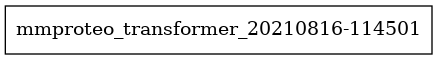

In [45]:
tf.keras.utils.plot_model(
    model=model,
    to_file=os.path.join(MODEL_PATH, "model.png"),
    show_shapes=True,
    expand_nested=True,
)

In [46]:
with open(os.path.join(MODEL_PATH, "summary.txt"), 'w') as file:
    def write_lines(line: str) -> None:
        file.write(line)
        file.write("\n")
    model.summary(print_fn=write_lines)
model.summary()

Model: "mmproteo_transformer_20210816-114501"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
on_device_embedding (OnDevic multiple                  10752     
_________________________________________________________________
transformer_encoder (Transfo multiple                  18903040  
_________________________________________________________________
transformer_decoder (Transfo multiple                  25200640  
_________________________________________________________________
relative_position_embedding  multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
Total params: 44,114,432
Trainable params: 44,114,432
Non-trainable params: 0
__________________

In [47]:
try:
    with open(os.path.join(MODEL_PATH, "model.json"), 'w') as file:
        file.write(model.to_json())

    with open(os.path.join(MODEL_PATH, "model.yaml"), 'w') as file:
        file.write(model.to_yaml())
except NotImplementedError as e:
    print("not implemented")

not implemented


## Training the Tensorflow Model

In [48]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 1e-05,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.98,
 'epsilon': 1e-09,
 'amsgrad': False}

In [49]:
decode_idx: Callable[[np.ndarray], np.ndarray] = np.vectorize(idx_to_char.get)

eval_evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[EVAL_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

train_evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[TRAIN_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

In [50]:
callback_list = callbacks.create_callbacks(
            tensorboard=True,
            progressbar=False,
            reduce_lr=False,
            early_stopping=False,
            checkpoints=True,
            csv=False,
            base_path=MODEL_PATH,
)

In [57]:
WARMUP_STEPS = 3000
STEPS_PER_EPOCH = 1  # 200

In [59]:
last_model = None

learning_rate = 10**-6
slowing_factor = 1

first_epoch = 1

while True:
    error_count = 0
    training_dataset = datasets[TRAIN_TYPE].repeat()
    validation_dataset = datasets[TEST_TYPE].repeat()
    
    aborted = False
    
    for epoch in range(first_epoch, 2):
        logger.info(f"epoch {epoch}:")
        learning_rate = EMBEDDING_WIDTH**-0.5 * min((epoch * STEPS_PER_EPOCH)**-0.5, (epoch * STEPS_PER_EPOCH) * WARMUP_STEPS**-1.5) / slowing_factor
        tf.keras.backend.set_value(model.optimizer.learning_rate, learning_rate)
        logger.debug(str(model.optimizer.get_config()))

        try:
            history = model.fit(
                x=training_dataset,
                validation_data=validation_dataset,
                validation_steps=STEPS_PER_EPOCH//5,
                epochs=epoch,
                steps_per_epoch=STEPS_PER_EPOCH,
                callbacks=callback_list,
                initial_epoch=epoch-1,
            )
            logger.debug(str(history.history))
        except tf.errors.InvalidArgumentError as e:
            logger.warning(f"Training error: {e}")
            error_count += 1
            if error_count > 10:
                logger.warning("abort training, because of too many NaN loss results")
                break

        print("Train:")
        eval_df, (x_eval, y_eval, y_pred) = train_evaluator.evaluate_model_visually(
            model=model,
            sample_size=5,
            keep_separator=True,
        )
        display(eval_df)
        
        print("Eval:")
        eval_df, (x_eval, y_eval, y_pred) = eval_evaluator.evaluate_model_visually(
            model=model,
            sample_size=5,
            keep_separator=True,
        )
        display(eval_df)
        
    else:
        aborted = True
    
    if not aborted:
        break
    
    last_model = model
    model = create_model()
    learning_rate *= 0.5
    slowing_factor *= 2
    first_epoch = 1
    break

2021-08-16 11:50:18,065 - mmproteo_attention_model: epoch 1:
2021-08-16 11:50:18,069 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 2.6895717e-07, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


1/1 [==============================] - 37s 37s/step - loss: 2.6033 - sparse_categorical_accuracy: 0.5653 - jaccard_batch_distance: 0.8598 - leuvenshtein_batch_distance: 2.8613


2021-08-16 11:50:58,109 - mmproteo_attention_model: DEBUG: {'loss': [2.6033127307891846], 'sparse_categorical_accuracy': [0.5652994513511658], 'jaccard_batch_distance': [0.8597973585128784], 'leuvenshtein_batch_distance': [2.861328125]}


Train:


,predicted,true
0,M V M R N E Q R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,N S S V A P T P Q R T V S T S S S S S S A A T S A R
1,H R H V H I H L R _,A V L E W M K S K
2,H L H K _ H Y V L M,K Y S I Q G L G K
3,H L L V R S L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,M A V I C N T C G L P E D L C A C G D L A K D S T K
4,M M K M F M Y R,E A N Q L R R


Eval:


,predicted,true
0,M S L M M M T G K Q E L M K _ _ _ _ _ _ _ _,L Y P F L K A E L F M H L P P E A L R E K
1,H M Q E M C Q Y L E G T H D,G V H V V T V N D Y L A K
2,H T V S G H N L T Q L T E N,K Y S T G H S E A I V T R
3,H D E L P D L V L S G I N R _ _ _ _ _ _ _ _,L D I V D P D G N L H H G N A K E F A M K
4,H S M T I S H I E F L M G K,T F A G K Q G D I Q A L K


2021-08-16 11:51:01,500 - mmproteo_attention_model: created new model 'mmproteo_transformer_20210816-115101'


In [60]:
eval_df, _ = train_evaluator.evaluate_model_visually(
    model=model,
    sample_size=2,
    keep_separator=True,
)
eval_df

,predicted,true
0,I H S K T S K H S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L S T E D G T S A Y A M T K L L D E F Q S T R Y E R
1,I Q L T V I R E N R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L M E R P Q I I V A N K M D M P D S E E N L A A F K


## Evaluating the Tensorflow Model

In [54]:
train_evaluator.evaluate_model(model)

25/78 [========>.....................] - ETA: 7:34 - loss: 2.4821 - sparse_categorical_accuracy: 0.5838 - jaccard_batch_distance: 0.8504 - leuvenshtein_batch_distance: 2.8770

KeyboardInterrupt: 